# Projet DATA832

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Lecture et visualisation des données

In [2]:
df = pd.read_csv('data/Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

### Moyenne et variance par feature 

In [4]:
# On garde seulement les valeurs numériques
df_num = df.drop(columns=['country'])

mean_values = df_num.mean()
variance_values = df_num.var()


print("Moyenne pour chaque feature:")
print(mean_values)

print("\nVariance pour chaque feature:")
print(variance_values)

Moyenne pour chaque feature:
child_mort       38.270060
exports          41.108976
health            6.815689
imports          46.890215
income        17144.688623
inflation         7.781832
life_expec       70.555689
total_fer         2.947964
gdpp          12964.155689
dtype: float64

Variance pour chaque feature:
child_mort    1.626423e+03
exports       7.514183e+02
health        7.545116e+00
imports       5.861042e+02
income        3.716439e+08
inflation     1.117398e+02
life_expec    7.908851e+01
total_fer     2.291734e+00
gdpp          3.359414e+08
dtype: float64


### Matrice de corrélation 

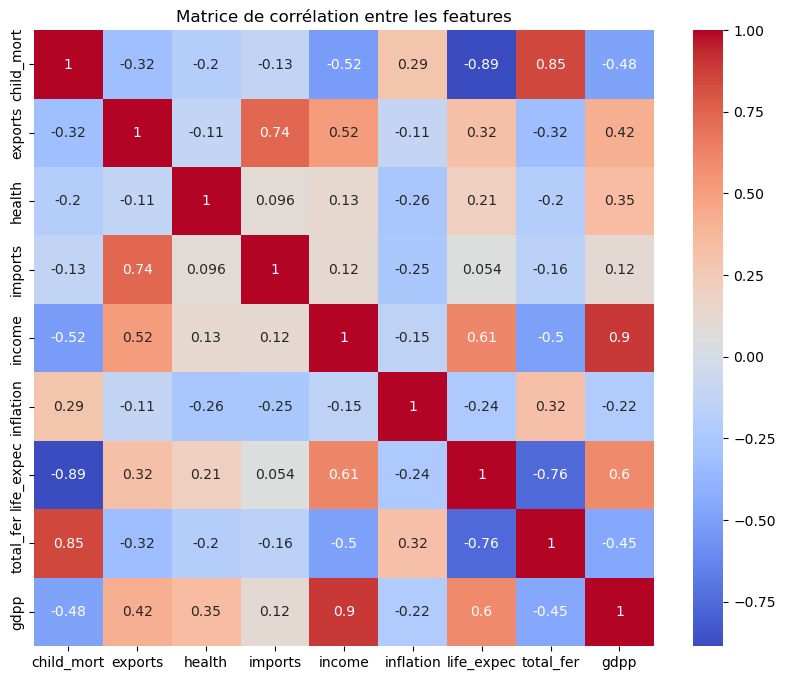

In [5]:
corr_matrix = df_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation entre les features')
plt.show()

On observe donc :

        Les features fortement corrélées (>0.5):
                - Income/GDPP : 0.9 -> deux features concernant le revenu des habitants du pays, donc il s'agit d'une corrélation logique
                - total_fert/child_mort : 0.85 -> deux features concernant les naissances, on observe ici que la mortalité enfantile est corrélée avec la fertilité totale
                - Exports/Imports : 0.74 -> corrélation entre la quantité d'import et d'export pour chaque pays
                - life_expec/income : 0.61 -> corrélation entre la durée de vie et le revenu
                - GDPP/life_expec : 0.6 -> corrélation entre la durée de vie et le PIB par hab (logique car fortement corrélé avec le revenu)
                - Income/Exports : 0.52 -> les revenus sont corrélés avec les exports (commerce à l'étranger donc cohérent)


        Les features fortement inversement corrélées (<-0.5) :
                - life_expec/child_mort : -0.89 -> la durée de vie et la mortalité enfantile sont inversement corrélés, cohérent car cela signifie qu'une plus grande partie de la population meurt jeune
                - life_expec/total_fer : -0.76 -> cohérent car total_fer et child_mort sont fortement corrélés
                - Income/child_mort : -0.52 -> suit le fait que la durée de vie est corrélé avec le revenu
                - Income/total_fert : -0.5 -> comme ci-dessus

### Distribution des valeurs pour chaque variable selon tous les pays 

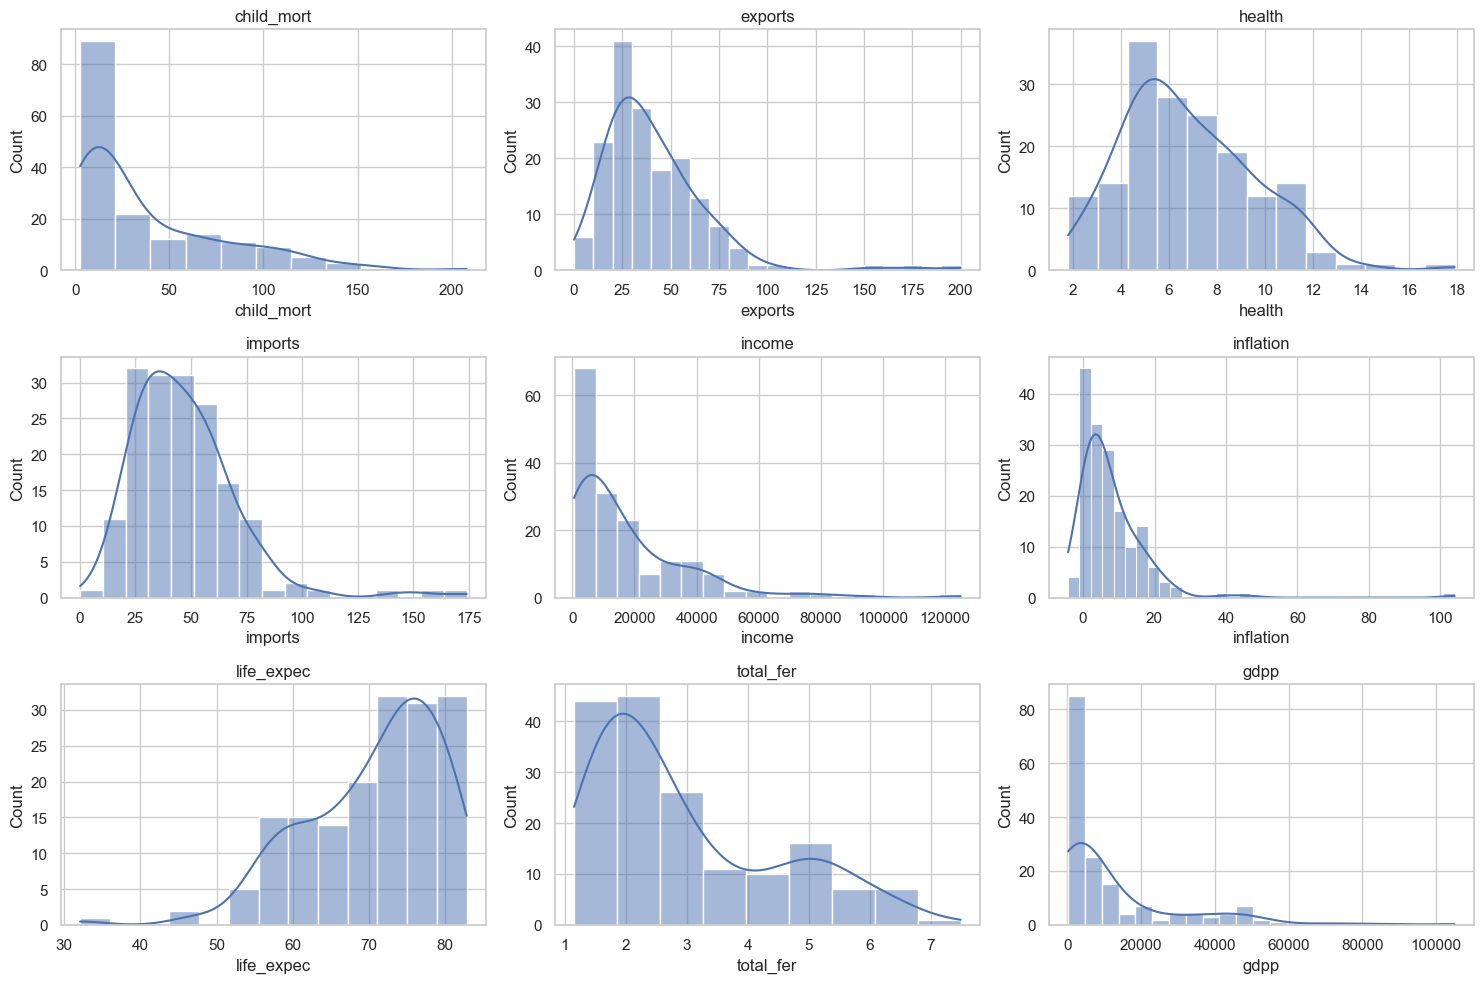

In [6]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_num.columns):
    plt.subplot(3, 3, i + 1)  
    sns.histplot(df_num[column], kde=True) 
    plt.title(column) 

plt.tight_layout()  
plt.show()  

On remarque bien sûr pour chaque feature des pics. Il sera nécessaire d'analyser si ces pics représentent les pays en développement, ou au contraire les pays nécessitant une aide. Par exemple, pour la durée de vie, on remarque que le pic se trouve à un âge assez avancé, ce qu'on pourrait relier à des pays plutôt développés. 

### Pays ayant les valeurs les plus faibles ou plus élevées par features

In [7]:
def plot_top_countries(df, feature, top_n=5, ascending=False):
    """
    Parametres:
        df (DataFrame): Input DataFrame 
        feature (str): nom de la feature
        top_n (int): nombre de pays à afficher
        ascending (bool): définit si on affiche les valeurs les plus faibles ou les plus élevées
    Returns:
        Aucun (affiche un histogramme)
    """
    # Tri du dataframe en fonction de la feature
    sorted_df = df.sort_values(by=feature, ascending=ascending)

    # Sélection des pays
    selected_countries = sorted_df.head(top_n)

    # Affichage
    plt.figure(figsize=(6, 3))
    sns.barplot(data=selected_countries, y='country', x=feature, orient='h')
    plt.title(f'Top {top_n} Countries by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()


Pour éviter de tout afficher à la suite, on va commencer par déterminer les features qui pourraient déterminer un pays développé lorsqu'elles sont élevées, et inversement.

    Features qui devraient être élevées :
        - Health
        - Income 
        - life_expec
        - gdpp

    Features qui devraient être faibles :
        - child_mort

    Features "neutres" (du moins par elles mêmes) : 
        - Import
        - Export
        - Inflation
        - total_fert

#### Analyse des features déterminant des pays développés

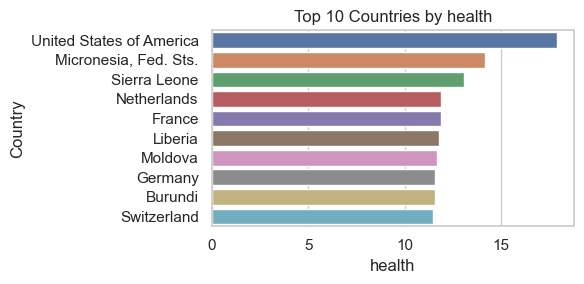

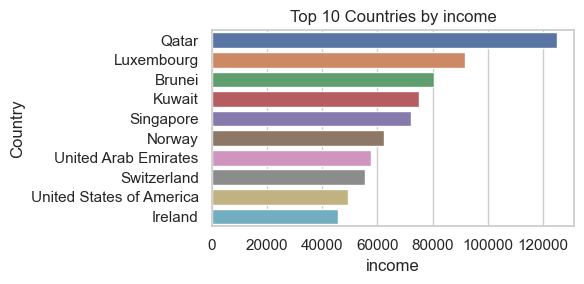

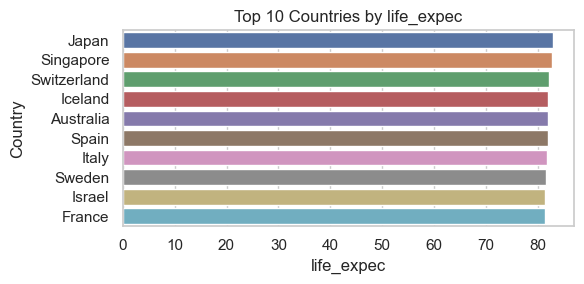

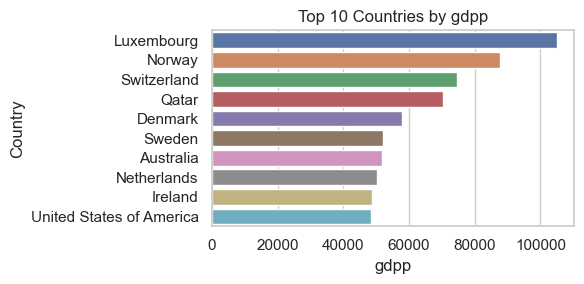

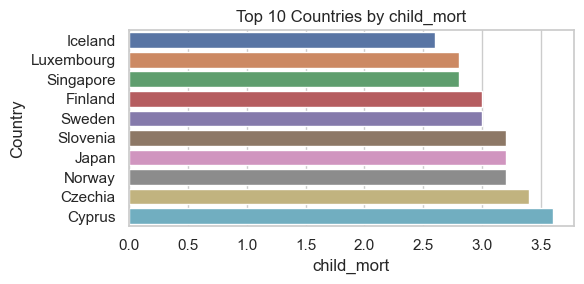

In [8]:
plot_top_countries(df, 'health', top_n=10)
plot_top_countries(df, 'income', top_n=10)
plot_top_countries(df, 'life_expec', top_n=10)
plot_top_countries(df, 'gdpp', top_n=10)
plot_top_countries(df, 'child_mort', top_n=10, ascending=True)

Pays avec plusieurs apparitions :
 - Etats-Unis

### Analyse des résultats

Pays ressortant souvent et leur résultats :
    

### PCA

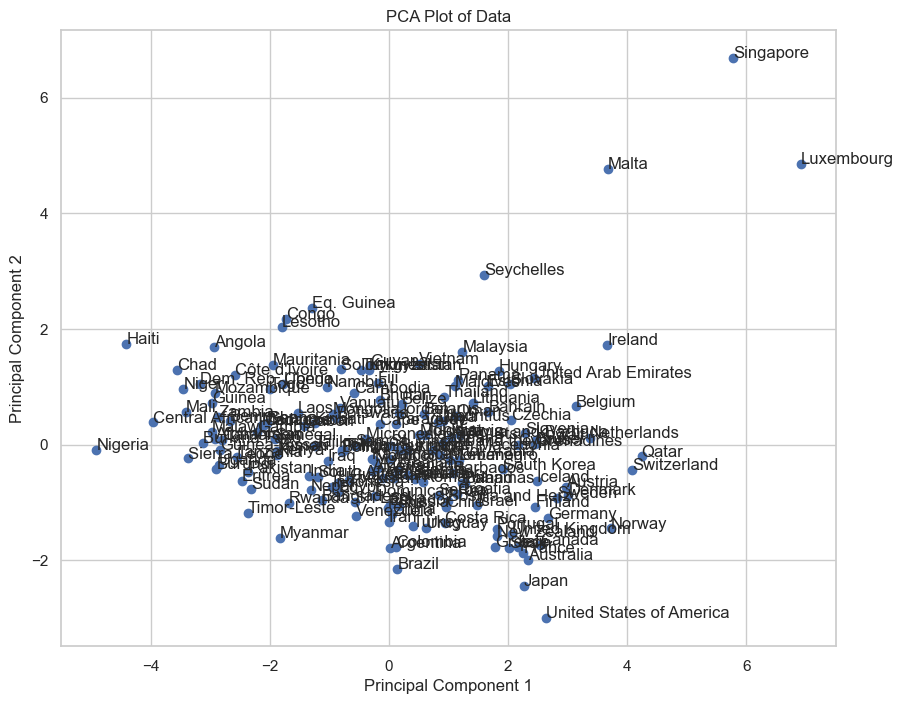

In [9]:
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
X = df.loc[:, features].values

countries = df['country'].tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'])

for i, country in enumerate(countries):
    plt.annotate(country, (df_pca.loc[i, 'PC1'], df_pca.loc[i, 'PC2']))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Data')
plt.grid(True)
plt.show()

On remarque une concentration de pays qu'on pourrait classer dans "Pas d'aide nécessaire" plutot à droite du scatterplot, avec notamment la Suisse et les Etats-Unis. Au contraire, à l'opposé, on retrouve les pays qu'on pourrait classer comme "à besoin d'aide", comme Haiti et le Nigeria. Pour les pays dans la catégorie "peut avoir besoin d'aide", on peut donc prendre un point au centre pour déterminer le centre de ce cluster, par exemple, la Micronésie.